In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf

from uncertainties import ufloat
from uncertainties.umath import *  # For mathematical operations with uncertainties
from uncertainties import unumpy 

In [36]:
# Read the ODS file
df = pd.read_excel("data.ods", engine="odf", sheet_name=None)  # Use sheet_name=None to read all sheets

# Load the .ods file
file_path = "data.ods"
sheets = pd.read_excel(file_path, sheet_name=None, engine="odf")

# Extract Sheet1
df1 = sheets["Sheet1"]

# Rename columns for clarity
df1.columns = ["temp_tin", "volt_tin", "temp_indium", "volt_indium"]

# Convert numeric columns
df1 = df1.iloc[1:].reset_index(drop=True)
df1 = df1.apply(pd.to_numeric, errors="coerce")

# Drop rows with NaN values for each material
df_tin = df1[["temp_tin", "volt_tin"]].dropna()
df_indium = df1[["temp_indium", "volt_indium"]].dropna()


In [37]:
# Print the first few rows of the first sheet
for sheet, data in df.items():
    print(f"Sheet: {sheet}")
    print(data)  # Display first few rows

Sheet: Sheet1
   temperature (K)  voltage (mV) temperature  voltage (mV).1
0              tin           NaN      Indium             NaN
1             4.14         166.0        3.42           -71.0
2             4.01         167.2       3.415           -71.5
3             3.86         167.3        3.41           -71.3
4             3.82         167.5         3.4           -71.3
5             3.81         167.5        3.36          -300.5
6             3.77         167.5        3.35          -301.0
7             3.75         167.6        3.31          -301.8
8             3.72         166.0         3.3          -302.0
9             3.71         157.0        3.21          -302.3
10            3.69          43.6         NaN             NaN
11            3.67          35.3         NaN             NaN
12            3.66          34.0         NaN             NaN
13            3.65          33.0         NaN             NaN
14            3.58          32.9         NaN             NaN
15        

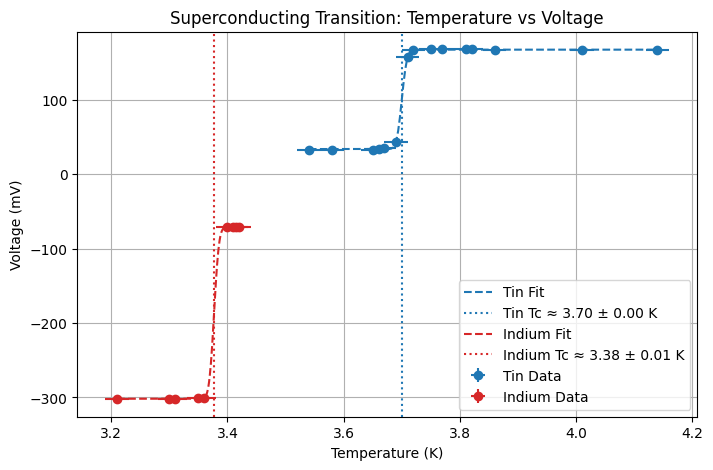

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf
from uncertainties import ufloat, unumpy

# Define the error function fit
def erf_fit(T, A, B, Tc, w):
    return A + B * erf((T - Tc) / w)

# Example data
data = {
    "temp_tin": [4.14, 4.01, 3.86, 3.82, 3.81, 3.77, 3.75, 3.72, 3.71, 3.69, 3.67, 3.66, 3.65, 3.58, 3.54],
    "volt_tin": [166.0, 167.2, 167.3, 167.5, 167.5, 167.5, 167.6, 166.0, 157.0, 43.6, 35.3, 34.0, 33.0, 32.9, 32.9],
    "temp_indium": [3.42, 3.415, 3.41, 3.4, 3.36, 3.35, 3.31, 3.3, 3.21, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    "volt_indium": [-71.0, -71.5, -71.3, -71.3, -300.5, -301.0, -301.8, -302.0, -302.3, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
}

# Create DataFrame
df1 = pd.DataFrame(data)

# Rename columns for clarity
df1.columns = ["temp_tin", "volt_tin", "temp_indium", "volt_indium"]

# Drop rows with NaN values for each material
df_tin = df1[["temp_tin", "volt_tin"]].dropna()
df_indium = df1[["temp_indium", "volt_indium"]].dropna()

# Add uncertainties to the data
df_tin["temp_tin"] = unumpy.uarray(df_tin["temp_tin"], 0.02)  # +/- 0.02 K
df_tin["volt_tin"] = unumpy.uarray(df_tin["volt_tin"], 0.1)    # +/- 0.1 mV
df_indium["temp_indium"] = unumpy.uarray(df_indium["temp_indium"], 0.02)  # +/- 0.02 K
df_indium["volt_indium"] = unumpy.uarray(df_indium["volt_indium"], 0.1)    # +/- 0.1 mV

# Define colors for consistency
colors = {"Tin": "tab:blue", "Indium": "tab:red"}

# Fit and plot for both materials
plt.figure(figsize=(8, 5))

for material, df, color in [
    ("Tin", df_tin, colors["Tin"]),
    ("Indium", df_indium, colors["Indium"])
]:
    # Extract data with uncertainties
    T_data = df.iloc[:, 0].values  # Temperature with uncertainty
    V_data = df.iloc[:, 1].values  # Voltage with uncertainty

    # Extract nominal values for fitting
    T_nominal = unumpy.nominal_values(T_data)
    V_nominal = unumpy.nominal_values(V_data)

    # Initial parameter guess: A=0, B=max-min, Tc=middle point, w=0.1
    p0 = [np.min(V_nominal), np.max(V_nominal) - np.min(V_nominal), np.median(T_nominal), 0.1]

    # Fit erf function to nominal values
    popt, pcov = curve_fit(erf_fit, T_nominal, V_nominal, p0=p0)

    # Extract fitted parameters and their uncertainties
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of the parameters
    A_fit, B_fit, Tc_fit, w_fit = popt
    A_err, B_err, Tc_err, w_err = perr

    # Generate smooth curve for the fit
    T_fit = np.linspace(min(T_nominal), max(T_nominal), 200)
    V_fit = erf_fit(T_fit, *popt)

    # Plot data points with error bars
    plt.errorbar(unumpy.nominal_values(T_data), unumpy.nominal_values(V_data),
                 xerr=unumpy.std_devs(T_data), yerr=unumpy.std_devs(V_data),
                 fmt="o", label=f"{material} Data", color=color)
    
    # Plot fitted curve
    plt.plot(T_fit, V_fit, "--", label=f"{material} Fit", color=color)

    # Mark estimated transition temperature with uncertainty
    plt.axvline(Tc_fit, color=color, linestyle=":",
                label=f"{material} Tc ≈ {Tc_fit:.2f} ± {Tc_err:.2f} K")

# Formatting
plt.xlabel("Temperature (K)")
plt.ylabel("Voltage (mV)")
plt.title("Superconducting Transition: Temperature vs Voltage")
plt.legend()
plt.grid()
plt.show()


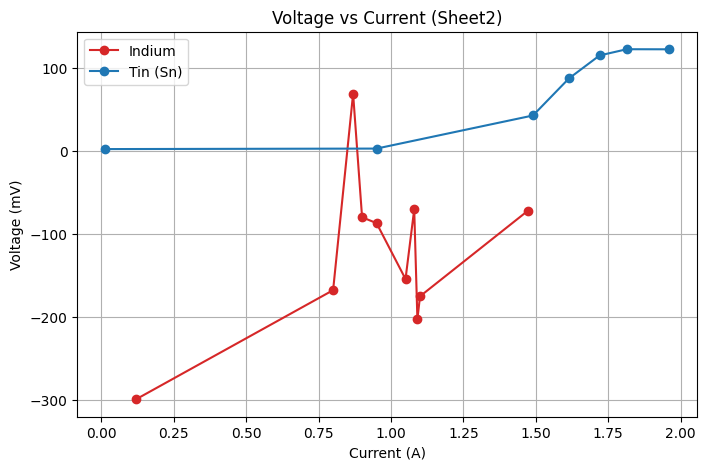

In [38]:
# Extract Sheet2
df2 = sheets["Sheet2"]

# Rename columns for clarity
df2.columns = ["curr_indium", "volt_indium", "curr_tin", "volt_tin"]

# Convert numeric columns (skip first row with material names)
df2 = df2.iloc[2:].reset_index(drop=True)
df2 = df2.apply(pd.to_numeric, errors="coerce")

# Separate DataFrames for Tin and Indium, then sort
df_tin = df2[["curr_tin", "volt_tin"]].dropna().sort_values(by="curr_tin")
df_indium = df2[["curr_indium", "volt_indium"]].dropna().sort_values(by="curr_indium")

# Plot Voltage vs Current
plt.figure(figsize=(8, 5))
plt.plot(df_indium["curr_indium"], df_indium["volt_indium"], "o-", label="Indium", color=colors["Indium"])
plt.plot(df_tin["curr_tin"], df_tin["volt_tin"], "o-", label="Tin (Sn)", color=colors["Tin"])
plt.xlabel("Current (A)")
plt.ylabel("Voltage (mV)")
plt.title("Voltage vs Current (Sheet2)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
sheets

{'Sheet1':    temp_tin  volt_tin temp_indium  volt_indium
 0       tin       NaN      Indium          NaN
 1      4.14     166.0        3.42        -71.0
 2      4.01     167.2       3.415        -71.5
 3      3.86     167.3        3.41        -71.3
 4      3.82     167.5         3.4        -71.3
 5      3.81     167.5        3.36       -300.5
 6      3.77     167.5        3.35       -301.0
 7      3.75     167.6        3.31       -301.8
 8      3.72     166.0         3.3       -302.0
 9      3.71     157.0        3.21       -302.3
 10     3.69      43.6         NaN          NaN
 11     3.67      35.3         NaN          NaN
 12     3.66      34.0         NaN          NaN
 13     3.65      33.0         NaN          NaN
 14     3.58      32.9         NaN          NaN
 15     3.54      32.9         NaN          NaN,
 'Sheet2':        temp_tin      volt_tin  temp_indium   volt_indium
 0        indium           NaN           Sn           NaN
 1   current (A)  voltage (mV)  current (A)  vo